In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from helper import plot_loss_function, load_and_prep_image, make_confusion_matrix, pred_and_plot, walk_through_dir, create_tensorboard_callback

# Transfer Learning Scaling Up

In [3]:
train_dir = 'data/101_food_classes_10_percent/train/'
test_dir = 'data/101_food_classes_10_percent/test/'

In [4]:
walk_through_dir('data/101_food_classes_10_percent/')

There are 2 directories and 0 images in 'data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in 'data/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/donuts'.
T

In [5]:
# Set up data inputs
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Metal device set to: Apple M1


2023-04-20 22:45:28.283967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-20 22:45:28.284157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

In [6]:
# Create checkpoint callback
checkpoint_path = 'data/101_food_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf._keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [7]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescale(1/255.)
], name='data_augmentation')

In [8]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setuo model architecture
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 5
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=EPOCHS,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5


2023-04-20 22:46:23.075874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7575]
	 [[{{node Placeholder/_0}}]]
2023-04-20 22:46:23.076465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7575]
	 [[{{node Placeholder/_4}}]]
2023-04-20 22:46:25.790164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - ETA: 0s - loss: 3.3749 - accuracy: 0.2671

2023-04-20 22:51:25.546764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25250]
	 [[{{node Placeholder/_4}}]]
2023-04-20 22:51:25.546988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25250]
	 [[{{node Placeholder/_4}}]]
2023-04-20 22:51:27.081334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - 334s 1s/step - loss: 3.3749 - accuracy: 0.2671 - val_loss: 2.5747 - val_accuracy: 0.4176
Epoch 2/5
237/237 [==============================] - 736s 3s/step - loss: 2.1916 - accuracy: 0.5014 - val_loss: 2.1006 - val_accuracy: 0.4918
Epoch 3/5
222/237 [===========================>..] - ETA: 1:16 - loss: 1.8167 - accuracy: 0.5715
systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



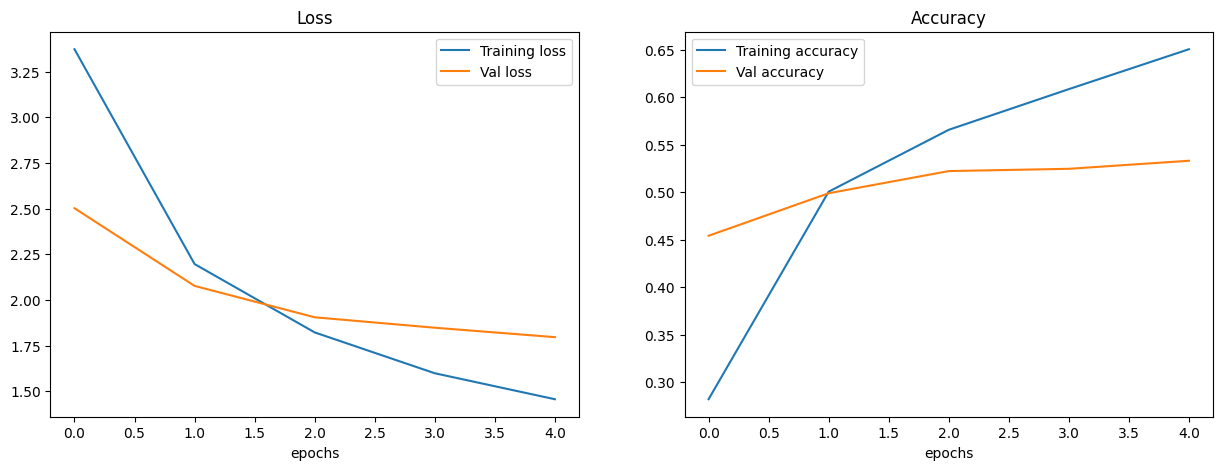

In [16]:
plot_loss_function(history_all_classes_10_percent)